## Training a MNIST classifier on persistence images and non-harmonic Laplacian eigenvalues

We first load the data from MNIST, and restrict to just 200 samples for faster computation during testing. 

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

# Load images in RAM (MNIST)
X_flat, y = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto', return_X_y=True)
y = y.astype(int)
images = X_flat.reshape(-1, 28, 28).astype(np.uint8)

In [2]:
N_SAMPLES = 200  # number of MNIST images to use

# Limit dataset
images_sample, y_sample = images[:N_SAMPLES], y[:N_SAMPLES]

## Baseline: pixels

We start with a baseline classifier that takes in raw pixels. We use a Random Forest classifier and cross-validate. 

In [3]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

def cross_validation_parallel(feature_extractor, images, y):
    # Process-based extraction (no GIL), then single parallel layer in CV
    X = np.vstack(Parallel(n_jobs=-1, backend="loky")(
        delayed(feature_extractor)(im) for im in images
    ))
    print("Shape:", X.shape)

    clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(clf, X, y, cv=cv,
                            scoring=["accuracy","f1_weighted"],
                            n_jobs=-1, return_estimator=False)

    a, f = scores["test_accuracy"], scores["test_f1_weighted"]
    print(f"Accuracy  {a.mean():.4f} ± {a.std():.4f} | folds: {a}")
    print(f"F1-weight {f.mean():.4f} ± {f.std():.4f} | folds: {f}")
    return X
    
def get_raw_pixels(img):
    return np.asarray(img, dtype=np.float32).ravel()

_ = cross_validation_parallel(get_raw_pixels, images_sample, y_sample)

Shape: (200, 784)
Accuracy  0.8100 ± 0.0561 | folds: [0.825 0.725 0.8   0.9   0.8  ]
F1-weight 0.8030 ± 0.0591 | folds: [0.81583333 0.71693362 0.80515873 0.8992316  0.77805195]


## Baseline: persistent homology (persistence image)

Next, we compute persistence images of the digits using Gudhi. Here's an example of the persistence images of a 8 and a 0.
Notice that we invert the image, so that empty regions have the highest value (255). This is so the filtrations add 'colored in' pixels first, and empty pixels last.

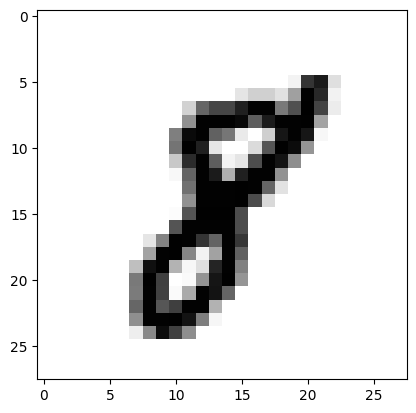

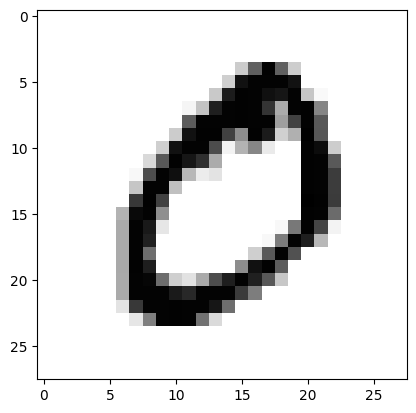

In [4]:
import matplotlib.pyplot as plt
img_8 = images_sample[17].astype(float)
img_8 = 255.0 - img_8  # superlevel via negation
plt.imshow(img_8, cmap='gray')
plt.figure()
img_0 = images_sample[1].astype(float)
img_0 = 255.0 - img_0  # superlevel via negation
plt.imshow(img_0, cmap='gray')

The persistence diagrams of the images tell us persistence homology sees two persistent holes in the 8, and one in the 0, as expected.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

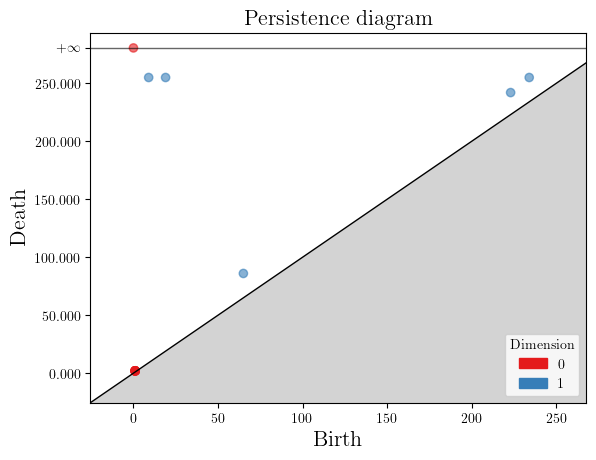

<Figure size 640x480 with 0 Axes>

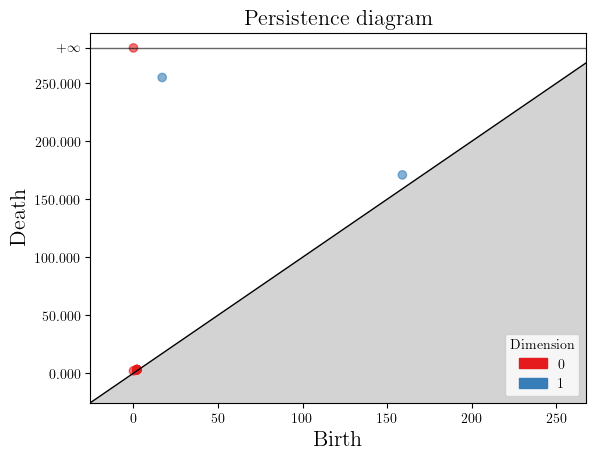

In [6]:
import gudhi as gd

complex_8 = gd.CubicalComplex(top_dimensional_cells=img_8)
dgmX = complex_8.persistence()
gd.plot_persistence_diagram(dgmX)
plt.figure()
complex_0 = gd.CubicalComplex(top_dimensional_cells=img_0)
dgmX = complex_0.persistence()
gd.plot_persistence_diagram(dgmX)

The persistence images also encode the presence of 2 holes in the 8 versus 1 hole in the 0 (note the higher intensity value in the top left corner),
as well as the high connectivity of the digits. 

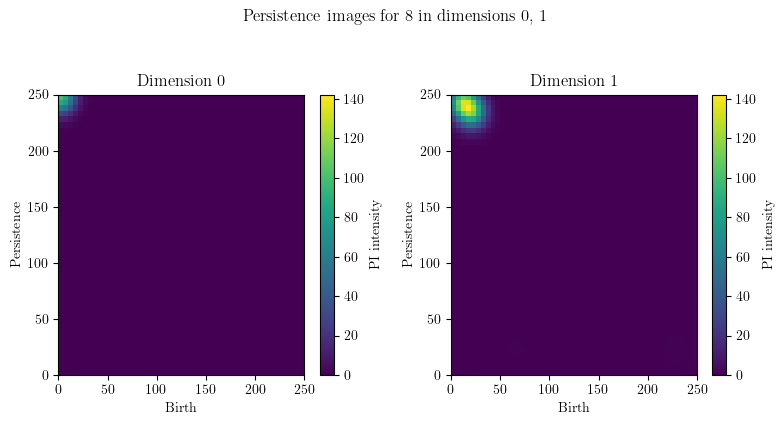

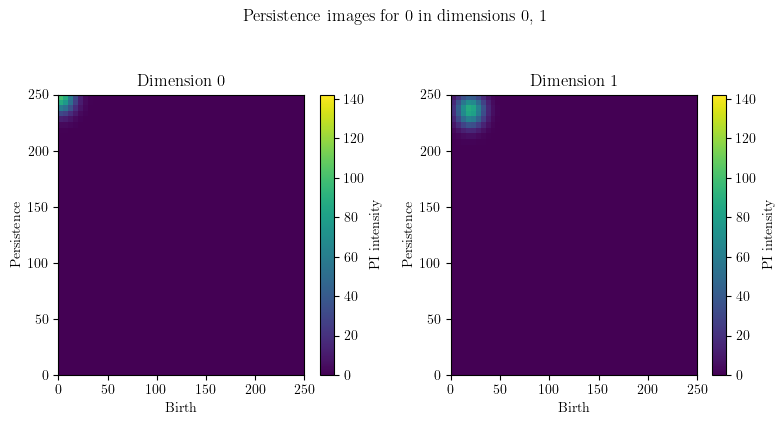

In [67]:
import gudhi.representations as gd
import matplotlib.pyplot as plt
import numpy as np

def replace_inf(arr, max_val):
    return np.where(np.isinf(arr), max_val, arr)

# 8
persistence_dim_0 = replace_inf(complex_8.persistence_intervals_in_dimension(0), 250)
persistence_image_constructor = gd.PersistenceImage(
    bandwidth=10, resolution=[50,50], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2
)
persistence_image_8 = persistence_image_constructor.fit_transform(
    [persistence_dim_0, complex_8.persistence_intervals_in_dimension(1)]
)

# 0
persistence_dim_0_0 = replace_inf(complex_0.persistence_intervals_in_dimension(0), 250)
# reuse the same constructor to keep parameters identical
persistence_image_0 = persistence_image_constructor.fit_transform(
    [persistence_dim_0_0, complex_0.persistence_intervals_in_dimension(1)]
)

# --- make all scales (color + axes) the same across all plots ---
to_img = lambda v: np.flip(np.reshape(v, (50,50)), 0)
imgs_all = [
    to_img(persistence_image_8[0]), to_img(persistence_image_8[1]),
    to_img(persistence_image_0[0]), to_img(persistence_image_0[1])
]
vmin = min(img.min() for img in imgs_all)
vmax = max(img.max() for img in imgs_all)
extent = (0, 250, 0, 250)

# Plot for complex_8
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    ax.set_title(f"Dimension {i}")
    im = ax.imshow(imgs_all[i], cmap="viridis", extent=extent,
                   aspect="auto", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, label="PI intensity")
    ax.set_xlabel("Birth"); ax.set_ylabel("Persistence")
fig.suptitle("Persistence images for 8 in dimensions 0, 1", y=1.05)
plt.tight_layout()
plt.show()

# Plot for complex_0
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    ax.set_title(f"Dimension {i}")
    im = ax.imshow(imgs_all[2 + i], cmap="viridis", extent=extent,
                   aspect="auto", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, label="PI intensity")
    ax.set_xlabel("Birth"); ax.set_ylabel("Persistence")
fig.suptitle("Persistence images for 0 in dimensions 0, 1", y=1.05)
plt.tight_layout()
plt.show()


We now train a classifier on the persistence images in dimension 1. We pick smaller resolution (5,5) in the hope that smaller features to be added later will not be 'drowned out' by the many pixels in a (50, 50) image. I didn't find significant difference in classification accuracy when downscaling the persistence images.

In [12]:
import gudhi as gd
import gudhi.representations
def persistence_image_dim_1(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5,5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([complex.persistence_intervals_in_dimension(1)])
    return pi.flatten()

X_dim1 = cross_validation_parallel(persistence_image_dim_1, images_sample, y_sample)

Shape: (200, 25)
Accuracy  0.3000 ± 0.0418 | folds: [0.325 0.25  0.25  0.325 0.35 ]
F1-weight 0.2407 ± 0.0389 | folds: [0.24883117 0.18375    0.21088023 0.26820818 0.29192719]


The accuracy is quite low: 30%!


This is actually exactly as expected if only using 1st homology: groups {0, 6, 9}, {8}, {1,2,3,4,5,7} are classified, 
so classification accuracy is $$\frac{3}{10} \cdot \frac{1}{3} + \frac{1}{10} \cdot 1 + \frac{6}{10} \cdot \frac{1}{6} = 0.3, $$ assuming uniform distribution of numbers in the test data.


For the grouping {0}, {8}, {1,2}, the classification accuracy should be 
$$ \frac{1}{4} \cdot 1 + \frac{1}{4} \cdot 1 + \frac{1}{2} \cdot \frac{1}{2} = 0.75. $$ 

We filter to only include these digits.

In [13]:
classes = {0, 8, 1, 2}
mask = np.isin(y, list(classes))

images_filtered = images[mask][:2000]
y_filtered = y[mask][:2000]
X_dim1_grouped = cross_validation_parallel(persistence_image_dim_1, images_filtered, y_filtered)

Shape: (2000, 25)
Accuracy  0.7045 ± 0.0134 | folds: [0.6875 0.6925 0.71   0.725  0.7075]
F1-weight 0.6811 ± 0.0118 | folds: [0.668909   0.66631531 0.68917668 0.69714721 0.68412405]


Close enough, I believe my hypothesis. 

The next thing to do is add dimension 0 homology to the persistence image. Digits tend to be connected, but perhaps we'll glean some information by how 'persistently' they are connected.

In [14]:
def persistence_image_dim_0(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5, 5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([replace_inf(complex.persistence_intervals_in_dimension(0), 250)])
    return pi.flatten()

X_dim0 = cross_validation_parallel(persistence_image_dim_0, images_sample, y_sample)

Shape: (200, 25)
Accuracy  0.2400 ± 0.0300 | folds: [0.3   0.225 0.225 0.225 0.225]
F1-weight 0.2107 ± 0.0324 | folds: [0.27025253 0.19843222 0.1825     0.184375   0.21818182]


Training on just dimension 0 has above 10% accuracy, so maybe it will add some accuracy to the dimension 1 classifier.

In [16]:
# Helper to feed the classifier multiple features
def concatenate(features):
    return lambda image: np.concatenate([f(image) for f in features])

In [18]:
X_dim0_dim1 = cross_validation_parallel(concatenate([persistence_image_dim_0, persistence_image_dim_1]), images_sample, y_sample)

Shape: (200, 50)
Accuracy  0.3300 ± 0.0187 | folds: [0.35  0.35  0.3   0.325 0.325]
F1-weight 0.3086 ± 0.0276 | folds: [0.33796537 0.3355303  0.27342102 0.27857143 0.31763709]


So, slightly better (notice we're feeding the model a vector twice the size now). Now let's see if adding the first nonzero eigenvalues of the 1-Laplacians will improve the model.

## Using smallest nonzero eigenvalues

First, we visualise the smallest nonzero eigenvalues of a 0 image, 

/var/folders/vw/75ns4gcj2pqgdh10pz8jrhjw0000gn/T/ipykernel_41057/2933323156.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


{2: {(34, 51): [0.6420337941043353], (59, 77): [0.39421447955859606], (25, 68): [0.6551821338094843], (0, 0): [4.0], (25, 34): [0.6551821338094843], (17, 42): [0.8197751722643466], (8, 25): [1.0215845614828405], (8, 77): [1.0215845614828405], (25, 51): [0.6551821338094843], (8, 17): [1.0215845614828405], (68, 68): [0.31704335850292276], (42, 59): [0.605398863184357], (51, 77): [0.521002844017611], (8, 51): [1.0215845614828405], (17, 34): [0.8197751722643466], (34, 42): [0.6420337941043353], (0, 77): [4.0], (17, 25): [0.8197751722643466], (77, 77): [0.023448171382561805], (0, 51): [4.0], (34, 34): [0.6420337941043353], (17, 68): [0.8197751722643466], (0, 42): [4.0], (0, 8): [4.0], (25, 59): [0.6551821338094843], (25, 42): [0.6551821338094843], (8, 68): [1.0215845614828405], (42, 77): [0.605398863184357], (68, 77): [0.31704335850292276], (8, 8): [1.0215845614828405], (59, 68): [0.39421447955859606], (59, 59): [0.39421447955859606], (25, 77): [0.6551821338094843], (8, 34): [1.021584561482

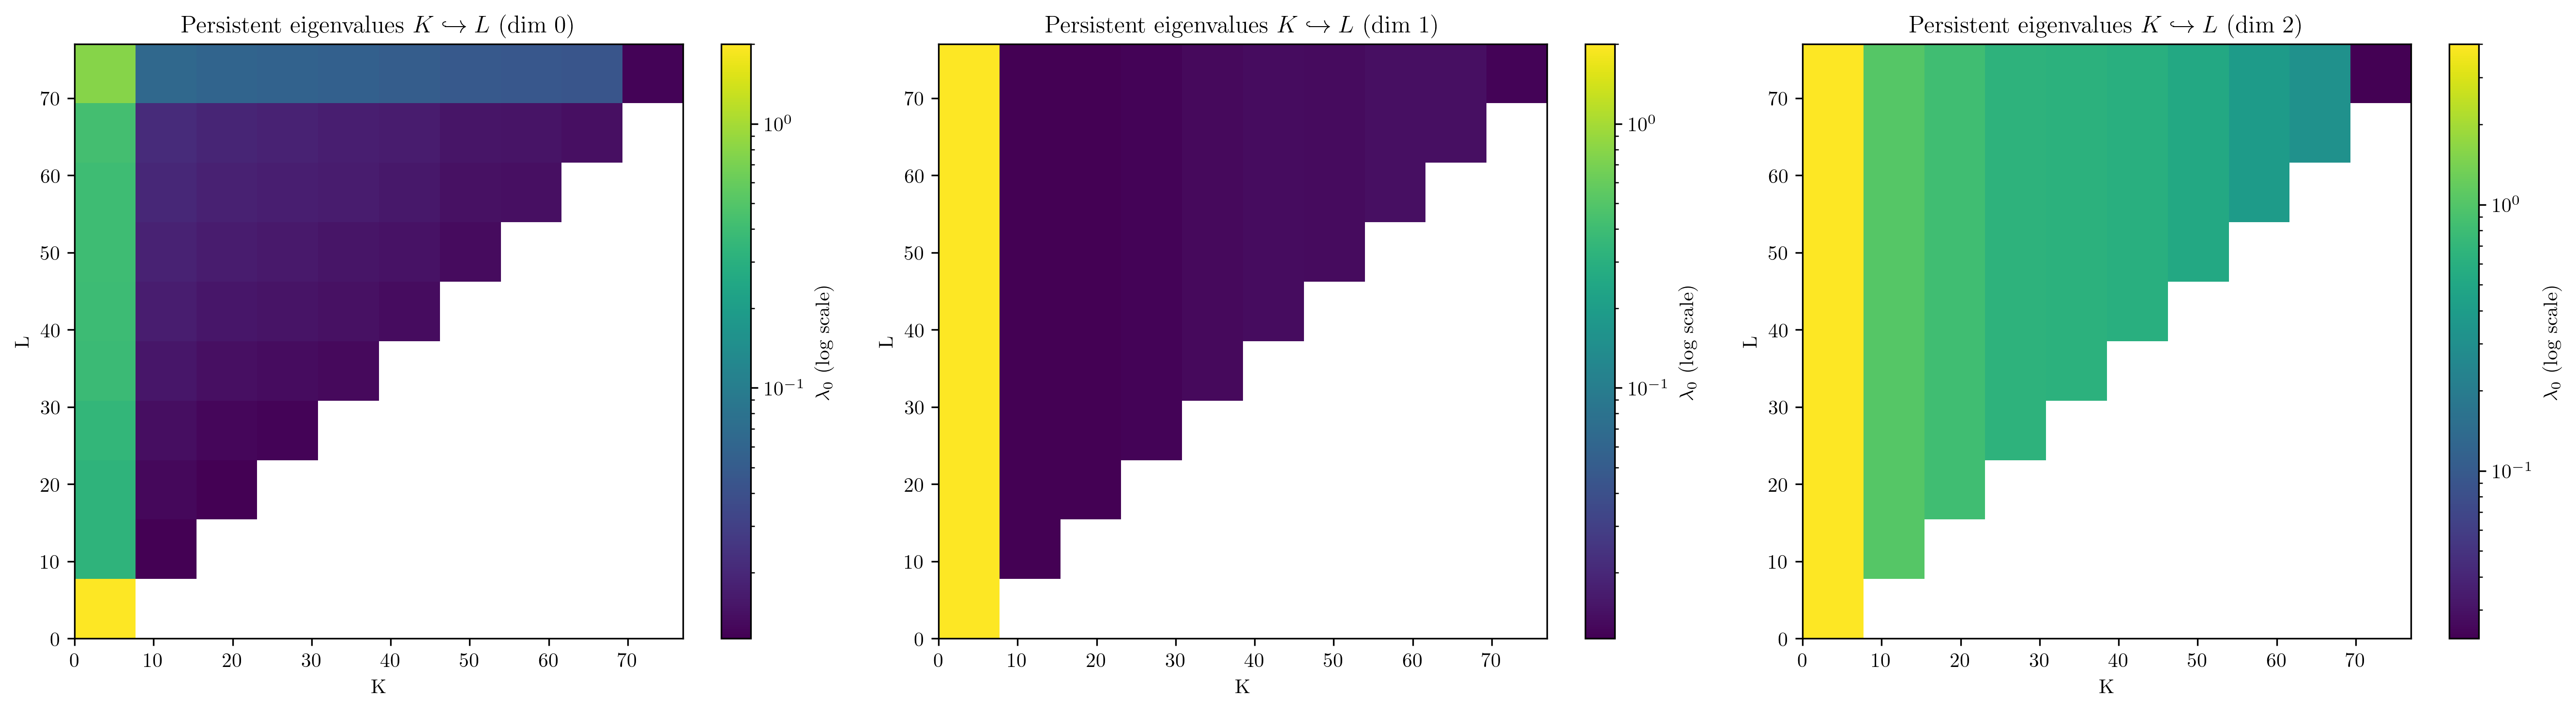

In [19]:
import persistent_laplacians.persistent_laplacians as pl
from persistent_laplacians.cubical_complexes import get_filtration_data
import numpy as np

image = 255.0 - images[1]
boundary_matrices, boundary_maps_index_dict, subsampled_filtration_indices = get_filtration_data(image, num_indices=10)
result = pl.smallest_eigenvalue(
    boundary_matrices,
    boundary_maps_index_dict,
    filtration_subsampling=subsampled_filtration_indices,
    zero_tol=1e-6,
    use_scipy=True,
    use_stepwise_schur=True,
)
print(result)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

dims = [0, 1, 2]
fig, axes = plt.subplots(1, len(dims), figsize=(6*len(dims), 5), dpi=300)
if len(dims) == 1:
    axes = [axes]

for ax, d in zip(axes, dims):
    pts = {k: v for (k, v) in result[d].items() if len(v) >= 1}

    xs = sorted({x for x, y in pts})
    ys = sorted({y for x, y in pts})

    heat = np.full((len(ys), len(xs)), np.nan)
    x_i = {x:i for i,x in enumerate(xs)}
    y_i = {y:i for i,y in enumerate(ys)}
    for (x,y), v in pts.items():
        heat[y_i[y], x_i[x]] = v[0]

    # log scale needs strictly positive values
    heat[~np.isfinite(heat)] = np.nan
    heat[heat <= 0] = np.nan
    vals = heat[np.isfinite(heat)]
    norm = LogNorm(vmin=np.nanmin(vals), vmax=np.nanmax(vals)) if vals.size else None

    im = ax.imshow(
        heat, origin='lower',
        extent=(min(xs), max(xs), min(ys), max(ys)),
        aspect='auto',
        norm=norm  # log color scale
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r'$\lambda_0$' + (' (log scale)' if norm is not None else ''))

    ax.set_xlabel("K")
    ax.set_ylabel("L")
    ax.set_title(rf'Persistent eigenvalues $K \hookrightarrow L$ (dim {d})')

plt.tight_layout()
plt.show()


Notice that in dimension 1 there are no 'persistent eigenvalues', for any pair (K, L) the value is actually that of (K, K). The same for dimension 2, but that's expected because there is no UP persistent Laplacian (no 3-simplices).
So for now we will take the non-persistent eigenvalues of dimension 1.
We first visualise them for an 8 and for a 0.

In [29]:
import persistent_laplacians.persistent_laplacians as pl
from persistent_laplacians.cubical_complexes import get_filtration_data
import numpy as np
import sys, os
from contextlib import contextmanager

@contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

def get_nonpersistent_eigenvalues_from_image(image):
    image = 255.0 - image
    boundary_matrices, boundary_maps_index_dict, subsampled_filtration_indices = get_filtration_data(image, num_indices=5)
    # Silence output for now, to avoid the runtime warning hit when k >= N for N * N square matrix, for k the desired eigenvalues.
    with suppress_output():
        result = pl.smallest_eigenvalue(
            boundary_matrices,
            boundary_maps_index_dict,
            filtration_subsampling=subsampled_filtration_indices,
            zero_tol=1e-6,
            use_scipy=True,
            use_stepwise_schur=False,
        )
    # Filter result to nonpersistent dim 1 features
    nonpersistent_dim1 = [
        (k[0], v)
        for k, v in result[1].items()
        if k[0] == k[1]
    ]
    nonpersistent_dim1.sort(key=lambda x: x[0])
    # Return first element of each or zero if missing
    nonzero_eigs = np.array([vec[0] if vec else 0 for _, vec in nonpersistent_dim1])
    return nonzero_eigs

[2.         0.01392467 0.01565946 0.01618176 0.01172409]


<Figure size 640x480 with 0 Axes>

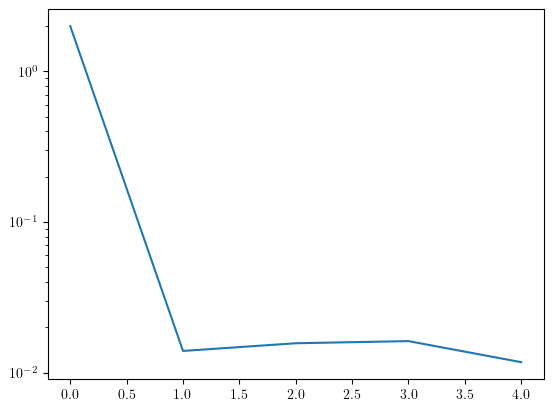

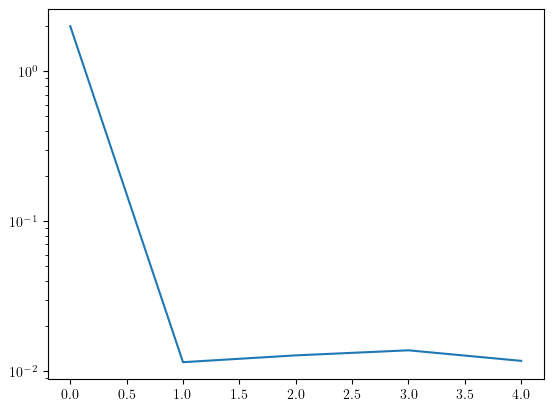

<Figure size 640x480 with 0 Axes>

In [30]:
# 8
nonpersistent_dim1_eigenvalues = get_nonpersistent_eigenvalues_from_image(images[17])
# first eigenvalue is quite large, skipping to see the others better
print(nonpersistent_dim1_eigenvalues)
plt.yscale("log")
plt.plot(nonpersistent_dim1_eigenvalues)
plt.figure()

# 0
nonpersistent_dim1_eigenvalues = get_nonpersistent_eigenvalues_from_image(images[1])
plt.yscale("log")
plt.plot(nonpersistent_dim1_eigenvalues)
plt.figure()


In [31]:
X_eig_dim1 = cross_validation_parallel(get_nonpersistent_eigenvalues_from_image, images_sample, y_sample)

Shape: (200, 5)
Accuracy  0.2650 ± 0.0300 | folds: [0.25  0.3   0.25  0.3   0.225]
F1-weight 0.2483 ± 0.0356 | folds: [0.21529915 0.2839369  0.24162698 0.29450216 0.2060878 ]


Now we will simply append this data to the computation of the persistence image in dimension 1. 

In [32]:
dim1_pi_dim_1_nonpersistent_eigen = concatenate([persistence_image_dim_1, get_nonpersistent_eigenvalues_from_image])
X_dim1_pi_dim_1_nonpersistent_eigen = cross_validation_parallel(dim1_pi_dim_1_nonpersistent_eigen, images_sample, y_sample)

Shape: (200, 30)
Accuracy  0.3150 ± 0.0644 | folds: [0.375 0.325 0.2   0.3   0.375]
F1-weight 0.2956 ± 0.0563 | folds: [0.31463203 0.29998279 0.19757118 0.29349206 0.37218615]


We'll try with both persistence images and the nonpersistent eigenvalues in dimension 1.

In [34]:
dim0_pi_dim1_pi_dim_1_nonpersistent_eigen = concatenate([persistence_image_dim_0, persistence_image_dim_1, get_nonpersistent_eigenvalues_from_image])
X_dim1_pi_dim_0_pi_dim_1_nonpersistent_eigen = cross_validation_parallel(dim0_pi_dim1_pi_dim_1_nonpersistent_eigen, images_sample, y_sample)

Shape: (200, 55)
Accuracy  0.3650 ± 0.0436 | folds: [0.35  0.3   0.35  0.4   0.425]
F1-weight 0.3340 ± 0.0494 | folds: [0.29884199 0.27214286 0.3189899  0.37156593 0.40828283]


## Summary of classification results
The best classification accuracy so far comes from persistence images in dimension 1 and 2 + dim 1 eigenvalues.
With this much power none of the pairs make significance for a Wilcoxon test with Bonferroni correction.

## There are lots more things to look into...
- How changing the parameters per feature (num indices, size of image) affects classification accuracy,
- How other dimensions of the eigenvalues do in classification, ...
But it seems that the nonpersistent eigenvalues add some information to the dimension 0 + dimension 1 persistence image classifiers. 


Next, I want to understand what the features are extracting out of the images. Below, I plot confusion matrices of the classifiers and UMAP visualisations of the features to see if there is clear clustering. 

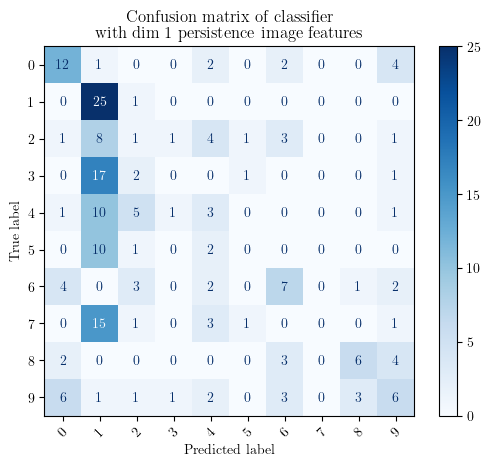

In [41]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def plot_confusion_matrix(X, y_sample, title="Confusion Matrix"):
    # Get out-of-fold predictions
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred = cross_val_predict(clf, X, y_sample, cv=cv, n_jobs=-1)

    # Confusion matrix
    cm = confusion_matrix(y_sample, y_pred)

    # Nicely plotted
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_sample))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()

    return X

_ = plot_confusion_matrix(X_dim1, y_sample, "Confusion matrix of classifier\nwith dim 1 persistence image features")

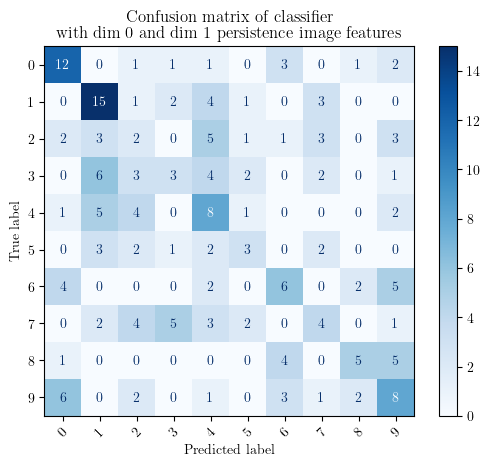

In [42]:
_ = plot_confusion_matrix(X_dim0_dim1, y_sample, "Confusion matrix of classifier\nwith dim 0 and dim 1 persistence image features")

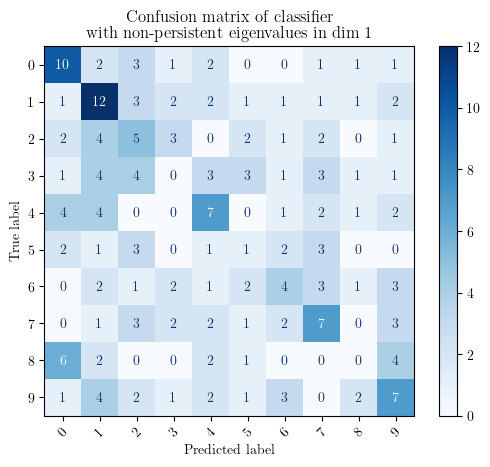

In [43]:
_ = plot_confusion_matrix(X_eig_dim1, y_sample, "Confusion matrix of classifier\nwith non-persistent eigenvalues in dim 1")

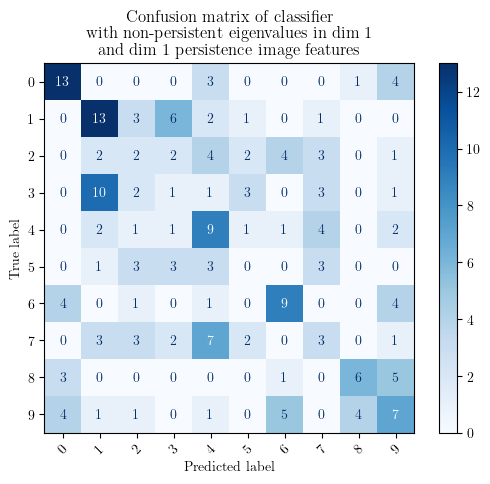

In [46]:
_ = plot_confusion_matrix(X_dim1_pi_dim_1_nonpersistent_eigen, y_sample, "Confusion matrix of classifier\nwith non-persistent eigenvalues in dim 1\nand dim 1 persistence image features")

Next, UMAP plots of the features in 2 dimensions.

/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


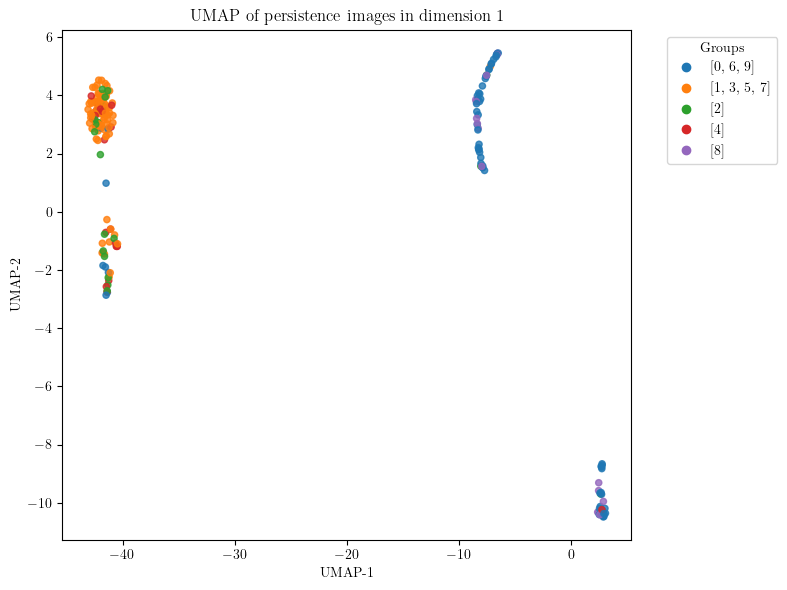

/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


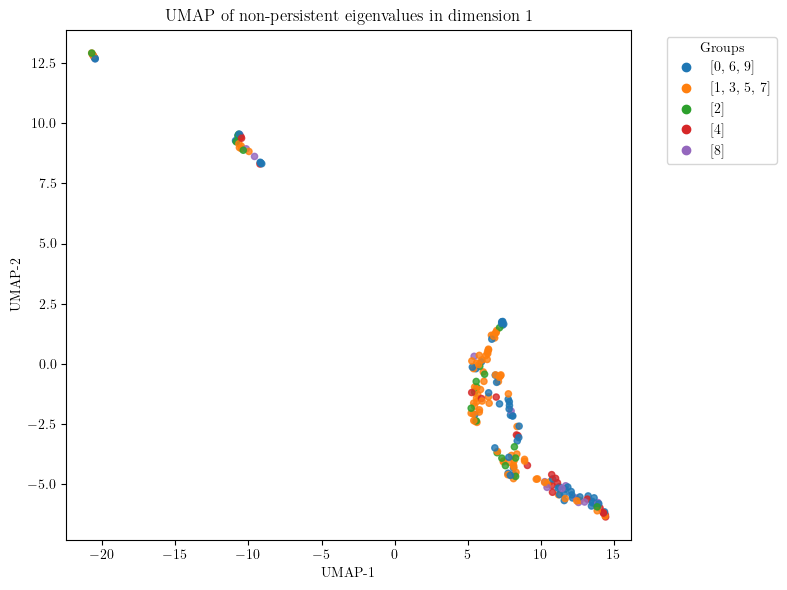

/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


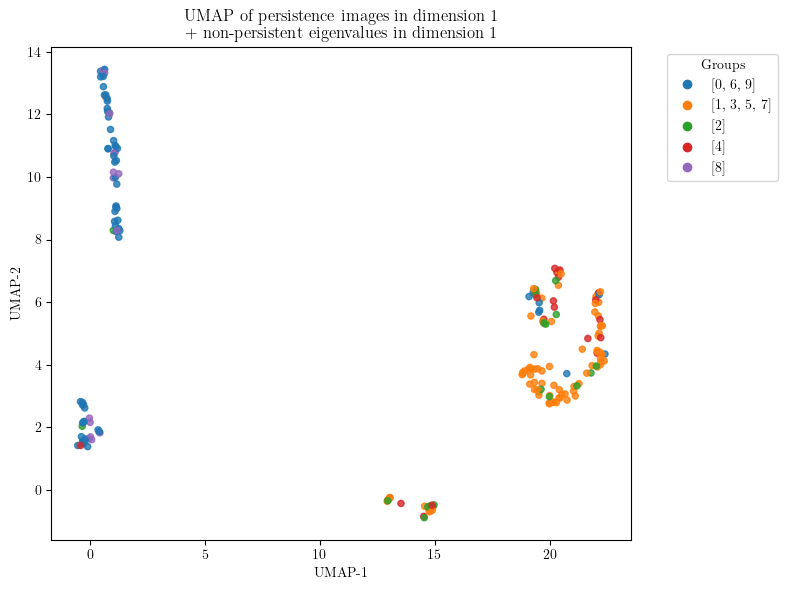

/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


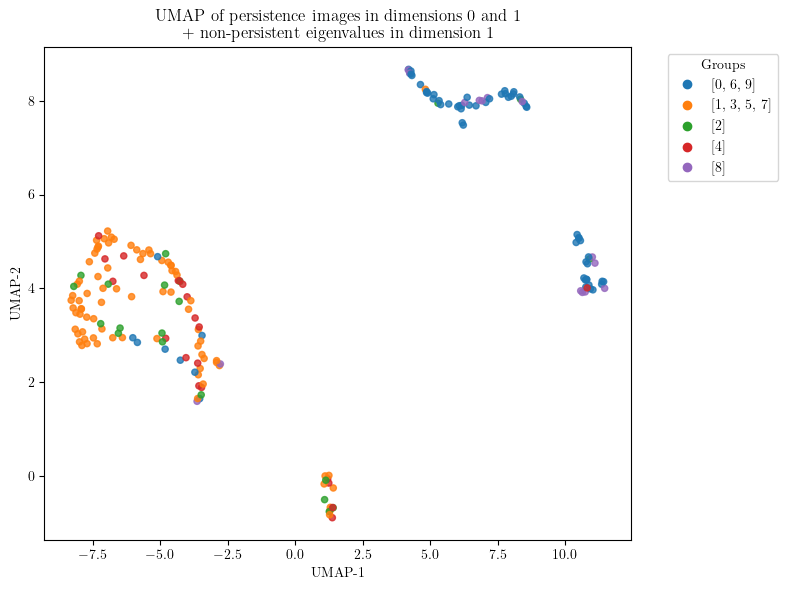

In [105]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap, BoundaryNorm

def umap_grouped_plot(
    X, labels, groups, group_names=None, scale=False,
    n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42,
    show_unknown=True,
    title=None
):
    # optional scaling
    if scale:
        X = StandardScaler().fit_transform(X)

    # UMAP (2D)
    Z = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False).fit_transform(X)

    # map label -> group id
    label2group = {int(lbl): gid for gid, grp in enumerate(groups) for lbl in grp}
    g_ids = np.array([label2group.get(int(y), -1) for y in labels], dtype=int)

    # discrete colors: gid k -> color k (fixed)
    n_groups = len(groups)
    base = plt.get_cmap("tab10")
    colors = [base(i % base.N) for i in range(n_groups)]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, n_groups + 0.5, 1), cmap.N)

    plt.figure(figsize=(8, 6))
    known = g_ids != -1
    plt.scatter(Z[known, 0], Z[known, 1], c=g_ids[known],
                cmap=cmap, norm=norm, s=20, alpha=0.8)

    # unknowns (labels not in any group)
    if show_unknown and (~known).any():
        plt.scatter(Z[~known, 0], Z[~known, 1], c="lightgray", s=15, alpha=0.6, label="Other")

    # legend with exact group colors
    handles, texts = [], []
    for gid in range(n_groups):
        h = plt.Line2D([0], [0], marker='o', linestyle='', markersize=6, color=colors[gid])
        handles.append(h)
        name = group_names[gid] if group_names else str(groups[gid])
        texts.append(name)
    if show_unknown and (~known).any():
        handles.append(plt.Line2D([0], [0], marker='o', linestyle='', markersize=6, color='lightgray'))
        texts.append("Other")

    plt.legend(handles, texts, title="Groups", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(title if title else "UMAP of Persistence Images")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout(); plt.show()
    return Z

Z_dim1 = umap_grouped_plot(X_dim1, y_sample, [[0, 6, 9], [1, 3, 5, 7], [2], [4], [8]], title="UMAP of persistence images in dimension 1")
Z_eig_dim1 = umap_grouped_plot(X_eig_dim1, y_sample, [[0, 6, 9], [1, 3, 5, 7], [2], [4], [8]], title="UMAP of non-persistent eigenvalues in dimension 1")
Z_dim1_pi_dim_1_nonpersistent_eigen = umap_grouped_plot(X_dim1_pi_dim_1_nonpersistent_eigen, y_sample, [[0, 6, 9], [1, 3, 5, 7], [2], [4], [8]], title="UMAP of persistence images in dimension 1\n + non-persistent eigenvalues in dimension 1")
Z_dim1_pi_dim_0_pi_dim_1_nonpersistent_eigen = umap_grouped_plot(X_dim1_pi_dim_0_pi_dim_1_nonpersistent_eigen, y_sample, [[0, 6, 9], [1, 3, 5, 7], [2], [4], [8]], title="UMAP of persistence images in dimensions 0 and 1\n + non-persistent eigenvalues in dimension 1")

To better visualize the UMAP, we put the persistence images, the digits, and the eigenvalue plots as hoverable images on top of the dots, following the UMAP tutorial.

In [103]:
from io import BytesIO
from PIL import Image
import base64
def embeddable_image_mpl(data, *, cmap='gray', figsize=(1.5, 1.5), dpi=120):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(data, cmap=cmap)
    ax.axis('off')
    plt.subplots_adjust(0, 0, 1, 1)
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    return 'data:image/png;base64,' + base64.b64encode(buf.getvalue()).decode()

In [85]:
from bokeh.plotting import output_notebook

output_notebook()

Loading BokehJS ...

In [107]:
import numpy as np, base64
from io import BytesIO
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CategoricalColorMapper, HoverTool
from bokeh.palettes import Spectral10
from bokeh.io import save
import pandas as pd

def embeddable_sparkline(vals, y_min, y_max, width=120, height=60):
    vals = np.asarray(vals, dtype=float)
    eps = max(1e-12, 1e-6 * (y_max if np.isfinite(y_max) else 1.0))
    vals_plot = np.clip(vals, eps, None)

    fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
    ax.set_yscale('log')
    ax.plot(range(len(vals_plot)), vals_plot, linewidth=2)
    ax.set_xlim(0, len(vals_plot)-1)
    ax.set_ylim(max(eps, y_min), max(eps*10, y_max))
    ax.axis('off'); plt.subplots_adjust(0, 0, 1, 1)

    buf = BytesIO(); fig.savefig(buf, format='png'); plt.close(fig)
    return 'data:image/png;base64,' + base64.b64encode(buf.getvalue()).decode()

to_img = lambda v: np.flip(np.reshape(v, (5,5)), 0)

def bokeh_plot(Z, images_sample, y_sample, X_dim1, X_eig_dim1, title="UMAP of MNIST"):

  digits_df = pd.DataFrame(Z, columns=('x', 'y'))
  digits_df['digit'] = [str(x) for x in y_sample]
  digits_df['image'] = [embeddable_image_mpl(x) for x in images_sample]
  digits_df['pi0']   = [embeddable_image_mpl(to_img(v)) for v in X_dim1]

  # global y-scale for consistent line intensity across samples
  eig_arr = np.asarray([np.asarray(v, dtype=float) for v in X_eig_dim1])
  y_min, y_max = np.nanmin(eig_arr), np.nanmax(eig_arr)
  digits_df['eig']  = [embeddable_sparkline(v, y_min, y_max) for v in X_eig_dim1]

  datasource = ColumnDataSource(digits_df)
  factors = sorted(digits_df['digit'].unique().tolist())
  color_mapping = CategoricalColorMapper(factors=factors, palette=Spectral10)

  plot_figure = figure(
      title=title,
      width=600, height=600,
      tools=('pan, wheel_zoom, reset')
  )

  plot_figure.add_tools(HoverTool(tooltips="""
  <div style="display:flex; gap:10px; align-items:center;">
    <div>
      <img src='@image' width="50" height="50" style='margin:4px; border:1px solid #ccc;'/>
      <div style="text-align:center; font-size:11px;">digit</div>
    </div>
    <div>
      <img src='@pi0' width="50" height="50" style='margin:4px; border:1px solid #ccc;'/>
      <div style="text-align:center; font-size:11px;">PI (first)</div>
    </div>
    <div>
      <img src='@eig' width="120" height="60" style='margin:4px; border:1px solid #ccc;'/>
      <div style="text-align:center; font-size:11px;">eig len=5</div>
    </div>
    <div style="margin-left:6px;">
      <span style='font-size:14px; color:#224499'>Label:</span>
      <span style='font-size:16px'>@digit</span>
    </div>
  </div>
  """))

  plot_figure.scatter(
      'x','y', source=datasource,
      color=dict(field='digit', transform=color_mapping),
      line_alpha=0.6, fill_alpha=0.6, size=4
  )

  show(plot_figure)
  # save(plot_figure, filename="/tmp/dim1_pi_dim1_eig.html")

bokeh_plot(Z_dim1, images_sample, y_sample, X_dim1, X_eig_dim1, title="UMAP of persistence images in dim 1")
bokeh_plot(Z_eig_dim1, images_sample, y_sample, X_dim1, X_eig_dim1, title="UMAP of eigenvalues in dim 1")
bokeh_plot(Z_dim1_pi_dim_0_pi_dim_1_nonpersistent_eigen, images_sample, y_sample, X_dim1, X_eig_dim1, title="UMAP of persistence images in dimensions 0, 1\nand eigenvalues in dim 1")